## Calculating a cutoff fitness score for cell line specific essentiality

Determine a cut-off score using Gaussian mixture models

**Input**: genes scores, the result of running CERES - a score for each gene in each cell line.

**Output:** cutoff score to use for calling genes essential / not essential in each cell line = **-0.47**

In [17]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
from sklearn import mixture
import sys
sys.path.append('../2_data_analysis')

%load_ext autoreload
%autoreload 1
from graphing_utils import *
%aimport graphing_utils

get_local_data_path = lambda folders, fname: os.path.normpath('../data/' +'/'.join(folders) +'/'+ fname)

# Scores should be rows=cell lines, cols=genes
file_gene_scores = get_local_data_path(['processed','depmap19Q1'], 'gene_scores_11_07_19.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
scores = pd.read_csv(file_gene_scores, index_col=0)
scores = scores.set_index('cell_line')
print('Num genes w/ scores: ' + str(scores.shape[1]))

Num genes w/ scores: 16540


In [11]:
scores[:1]

,8036,55967,55153,25940,23224,116071,114803,1967,23014,29957,...,128344,55249,84304,5869,57818,5273,84952,11046,90594,400
cell_line,,,,,,,,,,,,,,,,,,,,,
ACH-000601,-0.117838,-0.083374,-0.75716,-0.07252,-0.012776,-0.119112,0.053607,-1.092377,-0.234541,-0.018627,...,-0.18303,-0.096821,-0.092369,0.004617,0.010656,-0.008256,0.003173,-0.062839,-0.016976,-0.154559


Text(0.5, 0, 'Score')

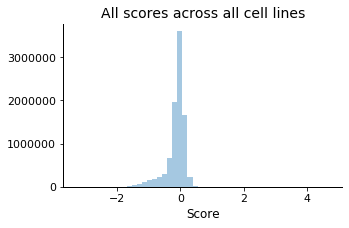

In [12]:
f, ax = plt.subplots(1, 1, figsize=(5,3))
sns.distplot(scores.values.flatten(), kde=False, bins=50, ax=ax)
ax.set_title('All scores across all cell lines')
ax.set_xlabel('Score')

In [21]:
# Note: cut offs can differ slightly due to randomness
def find_best_gmm(scores, max_components=5):
    print('Fitting GMM with 1-5 components')
    results_df = pd.DataFrame(columns=['model','num_components', 'bic', 'aic'])
    for n in range(0, max_components):
        gmm = fit_gmm_w_n_components(scores, n)
        #gmm = mixture.GaussianMixture(n_components=(n+1)).fit(X)
        results_df.loc[n] = [gmm, n+1, gmm.bic(X), gmm.aic(X)]
    print('Best num component according to BIC: ', results_df[results_df.bic==results_df.bic.min()].num_components.values[0])
    print('Best num component according to AIC: ', results_df[results_df.aic==results_df.aic.min()].num_components.values[0])
    return results_df[results_df.aic==results_df.aic.min()].model.values[0]

def fit_gmm_w_n_components(scores, n_components):
    print('Fitting GMM with', n_components, 'components')
    # Reshape the scores into a 2-D array (of single element vectors)
    X = np.reshape(scores.values.flatten(), (-1, 1))
    gmm = mixture.GaussianMixture(n_components=n_components).fit(X)
    return gmm

In [25]:
# Fit GMM
num_components=3
if num_components == None:
    gmm = find_best_gmm(scores)
else:
    gmm = fit_gmm_w_n_components(scores, num_components)

Fitting GMM with 3 components


In [26]:
# Use GMM to predict label and derive cutoff
X = np.reshape(scores.values.flatten(), (-1, 1))
gmm_df = pd.DataFrame(X).rename(columns={0:'score'})
gmm_df['label'] = gmm.predict(X)
print('Cut-offs (mins): ')
for label in gmm_df.label.unique():
    print(label, ':', np.round(gmm_df[gmm_df.label == label].score.min(), 3))

Cut-offs (mins): 
0 : -0.192
2 : -3.298
1 : -0.477


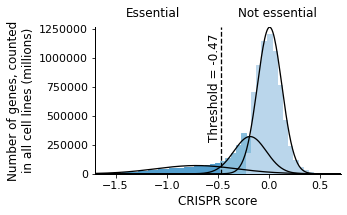

In [27]:
# Graph distribution colored according to prediction
f, ax = plt.subplots(1, 1, figsize=(4.4,2.7))
xlim = [-1.7, 0.7]
ax.set_xlim(xlim)
bins = np.linspace(gmm_df.score.min(), gmm_df.score.max(), 160)
colors = sns.color_palette("Blues")[3:0:-1]
sorted_mins = sorted([(0, gmm_df[gmm_df.label == 0].score.min()),
                      (1, gmm_df[gmm_df.label == 1].score.min()), 
                      (2, gmm_df[gmm_df.label == 2].score.min())], key=lambda tup: tup[1])
for i, component in enumerate(sorted_mins):
    sns.distplot(gmm_df[gmm_df.label == component[0]].score, kde=False, ax=ax, bins=bins, label=label, 
                 color=colors[i], hist_kws={"alpha": 1, 'edgecolor': colors[i]})
ax.set_xlabel('CRISPR score')
ax.set_ylabel('Number of genes, counted\nin all cell lines (millions)')

# Plot of the individual components of the mixture model
ax2 = ax.twinx()
x = np.reshape(np.linspace(gmm_df.score.min(), gmm_df.score.max(), 1000), (-1, 1))
pdf = np.exp(gmm.score_samples(x))
probability  = gmm.predict_proba(x)
pdf_individual = probability  * pdf[:, np.newaxis] # this is the same as doing a reshape w/ (-1, 1)
for idx in range(0, 3):
    ax2.plot(x, [i[idx] for i in pdf_individual], label=str(idx), color='black', linewidth=1.3)
ax2.set_xlim(xlim)
ax2.set_ylim([0, 2.2])
ax2.yaxis.set_ticks([]) # Don't show y ticks

# Extra annotations
ax.axvline(-0.47, color='black', linewidth=1.3, linestyle='--')
ax.text(-0.3, 1350000,'Not essential')
ax.text(-1.4, 1350000,'Essential')
ax.text(-0.6, 300000,'Threshold = -0.47', rotation=90)

plt.savefig('../figures/fig_1B.svg', bbox_inches='tight', dpi=300)